In [310]:
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize

In [ ]:
# PENDULUM

In [103]:
def pendulum(N, x0, deltat, delta, R=1e-1, g=9.81):
    xout = np.zeros((N+1, 2))  
    
    m = 1 
    yout = np.zeros(np.round_(int(N/delta)))
    
    xout[:,0] = x0[0,0]
    xout[:,1] = x0[0,1]
    

    for ii in range(N):
        q = np.dot(np.linalg.cholesky(Q),np.random.randn(2))
        qx1 = q[0]
        qx2 = q[1]
        xout[ii+1, 0] = (xout[ii, 0] + xout[ii, 1]*deltat) + qx1
        xout[ii+1, 1] = (xout[ii, 1] - g*np.sin(xout[ii, 0])*deltat) + qx2
        if ii%delta == 0:
            rx = np.sqrt(R) * np.random.randn(1)
            yout[int(ii/delta)] = np.sin(xout[ii, 0]) + rx 
    return xout, yout

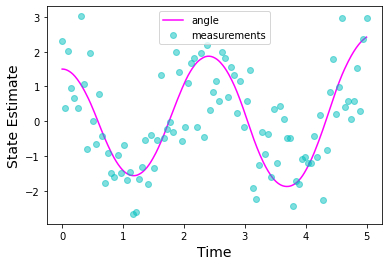

In [104]:
deltat = 0.01
x0 = np.array([[1.5,0]])

qc = 0.1
N = 500
deltaArray = np.array([5,10,20,40])
RArray = np.array([1, 0.1, 0.01, 0.001]) 

delta = deltaArray[0]
R = RArray[0]

Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])

xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)

T = N*deltat
t = np.linspace(0, T, N+1)
ty = np.linspace(0, T, int(N/delta))
plt.figure()
plt.plot(t, xout[:, 0], color='magenta', label='angle')
plt.plot(ty, yout, 'co', alpha=0.5, label='measurements')
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [ ]:
# KF

In [235]:
def linear_prediction_step(A, mean, cov, sigma, deltat):
    """Linear Prediction Step: Propagate uncertainty for one time step

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    A: (d, d) linear matrix
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    sigma (noise_cov): (d, d) process noise covariance, symmetric positive definite

    Returns
    -------
    pred_mean: (d, ) predicted mean phi(m_{k-1})
    pred_cov: (d, d) predicted covariance (ACA^T+Sigma)
    """

    pred_mean = np.array([[(mean[0] + mean[1]*deltat)],
                          [(mean[1] - g*np.sin(mean[0])*deltat)]])
    

    pred_cov = np.dot(A, np.dot(cov, A.T)) + sigma
    
    return pred_mean, pred_cov

In [265]:
def linear_update_step(data, H, mean, cov, gamma):
    """Linear Gaussian Inverse Problem
    
    Inputs
    ------
    data: (N) array of data
    H for us (A): (N, d) linear model
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (N, N) noise covariance matrix
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """
#     mean = mean.T
    mu =  np.sin(mean[0])
    delta = data - mu
    S = np.dot(H, np.dot(cov, H.T)) + gamma
    U = np.dot(cov, H.T)
    
    USinv = U/S
#     USinv = np.dot(U, (1/S))
#     print(mean.shape)
#     print(USinv.shape)  
#     update_mean = mean + np.dot(USinv, delta)
    update_mean = mean + USinv*delta
    update_cov = cov - np.dot(USinv, U.T)
#     print((USinv*delta).shape)
#     print(update_mean.shape)
#     print(update_cov.shape)
#     update_mean = update_mean.T

#     USinv = np.dot(U, np.linalg.inv(S))
#     update_mean = mean + np.dot(USinv, delta)
#     update_cov = cov - np.dot(USinv, U.T)   
      
#     update_mean = mean + np.dot(U, np.linalg.solve(S, delta))
#     update_cov = cov - np.dot(U, np.linalg.solve(S, U.T))

    update_mean = update_mean.squeeze()
    return update_mean, update_cov

In [291]:
def kalman_filter(N,data, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta):
    """The Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics 
    proc_cov: (d,d), process noise covariance
    H: (m, d), observation operator
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
#     print(prior_mean.shape)
    d = prior_mean.shape[0]
#     print(d)
#     N = data.shape[0]
#     m = data.shape[1]
    
    mean_store = np.zeros((d,N+1))
#     print(d)
#     print(N+1)
#     print(mean_store.shape)
#     mean_store[:,0] = np.copy(prior_mean)
    mean_store[:,0] = np.copy((prior_mean).squeeze())
#     print(mean_store)
#     print(mean_store.shape)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        
        mean_ii = np.reshape(mean_store[:,ii], (2, 1))
#         print(mean_ii)
        
        # update A
        
        A = np.array([[1, deltat], [-g*deltat*np.cos(mean_store[0,ii]), 1]])
        
        # Prediction
        
        pred_mean, pred_cov = linear_prediction_step(A, mean_ii, cov_store[:, :, ii], proc_cov, deltat)

        pred_mean = np.reshape(pred_mean,(2,1))
        
#         print(pred_mean)
#         print(pred_mean.shape)
        
        # update H
        
        H = np.array([[np.cos(int(pred_mean[0,:])), 0]])
#         print(pred_mean[0,:])
        
        # Update if measurement is available
        if ii%delta == 0:
        
            mean_store[:,ii+1], cov_store[:, :, ii+1] = linear_update_step(data[int(ii/delta)], H, pred_mean, pred_cov, meas_cov)
        
        else:
        
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [292]:
yuse = yout
g=9.81

# prior_mean = np.zeros((2)) # prior mean
prior_mean = x0.T # prior mean
prior_cov = np.eye(2)  # prior covariance
proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
meanpost, covpost = kalman_filter(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta)

In [294]:
t.shape

(501,)

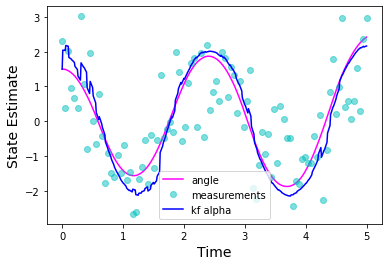

In [295]:
T = N*deltat
t = np.linspace(0, T, N+1)
ty = np.linspace(0, T, int(N/delta))
plt.figure()
plt.plot(t, xout[:, 0], color='magenta', label='angle')
plt.plot(ty, yout, 'co', alpha=0.5, label='measurements')
plt.plot(t, meanpost[0,:], color='blue', label='kf alpha')
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
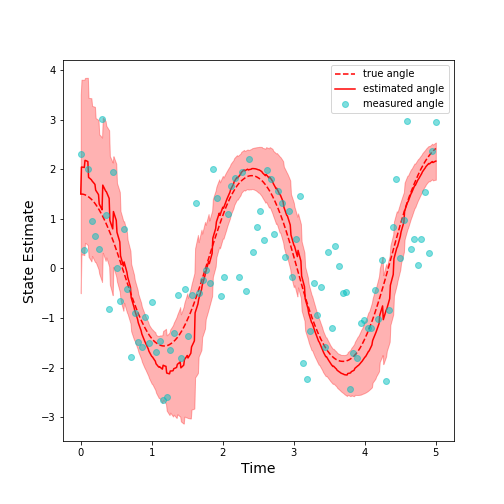

In [311]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs

std_devs = get_std(covpost) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='true angle')
# plt.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

plt.plot(t, meanpost[0,:], color='red', label='estimated angle')
# plt.plot(t, meanpost[:, 1], color='blue', label='state1')
plt.fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)
# plt.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
#                 color='blue', alpha=0.3)
#plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.plot(ty, yuse, 'co', alpha=0.5, label='measured angle')
# plt.plot(t[1:], yuse[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
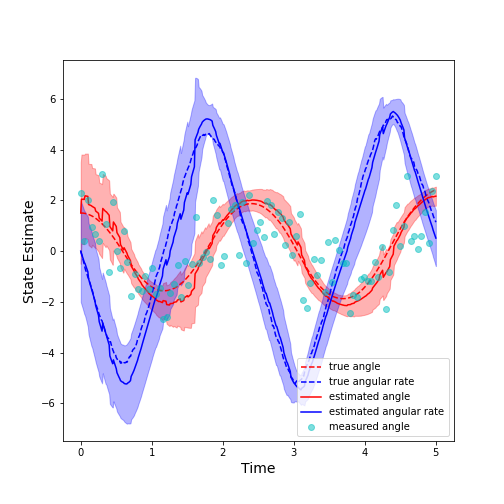

In [312]:
std_devs = get_std(covpost) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='true angle')
plt.plot(t, xout[:, 1],'--', color='blue', label='true angular rate')

plt.plot(t, meanpost[0,:], color='red', label='estimated angle')
plt.plot(t, meanpost[1,:], color='blue', label='estimated angular rate')
plt.fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)
plt.fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='blue', alpha=0.3)
#plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.plot(ty, yuse, 'co', alpha=0.5, label='measured angle')
# plt.plot(t[1:], yuse[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [ ]:
: colon, ; semicolon

In [301]:
std_devs

array([[1.        , 1.        ],
       [0.87982824, 1.00052288],
       [0.87991211, 1.00189887],
       ...,
       [0.18359116, 0.54213531],
       [0.18551669, 0.54650688],
       [0.18767825, 0.55135212]])

In [73]:
xout.shape


(501, 2)

In [74]:
print(x0)


[[1.5 0. ]]


In [ ]:
if ii%delta == 0
int(ii/delta)

In [41]:
deltaArray = np.array([5,10,20,40])

In [43]:
deltaArray[0]

5

In [ ]:
A = np.array([[1, deltat], [-g*np.cos(m_k_1), -0.5]])
H = np.array([[np.cos(mk_), 0]])

In [97]:
np.random.randn(2,1)

array([[-1.24776687],
       [-0.17459734]])

In [102]:
a = np.random.randn(2)
print(a)
qq = np.linalg.cholesky(Q)
print(qq)
np.dot(qq,a)

[-0.74060314  1.07790361]
[[0.00018257 0.        ]
 [0.02738613 0.01581139]]


array([-0.00013522, -0.0032391 ])

In [143]:
x0.shape[1]

(1, 2)

In [220]:
delta


5

In [ ]:
# 